# Hindcast evaluation of SEAS5 over the tropical Pacific

In [1]:
import os, glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from hyblim.utils import metric, enso
plt.style.use("../../paper.mplstyle")


## Load data

In [2]:
def get_staged_exp(datadir, pattern):
    """Get files matching the pattern in the datadir.

    Args:
    datadir: str
        Directory where the hindcast files are stored.
    pattern: str
        Pattern to match the hindcast files. 
        e.g. 'ifis_ens_0_t2m_*' will match all files starting with 'ifis_ens_0_t2m_'.
    
    Returns:
    ds: xarray.Dataset
        Concatenated dataset with init_time as the new dimension
    """
    full_pattern = os.path.join(datadir, pattern)
    # Find all files matching the pattern
    files = glob.glob(full_pattern)
    # Extract dates from filenames and convert to datetime
    init_dates = [pd.to_datetime(file.split('_')[-1][:8]) for file in files]

    ds_list = []
    for f in files:
        tmp = xr.open_dataset(f)
        # Replace time dimension with lag dimension i.e. 0 to len(time) 
        tmp = tmp.rename({'time': 'lag'})
        tmp['lag'] = np.arange(1, len(tmp.lag)+1)
        ds_list.append(tmp)

    return xr.concat(ds_list, dim=pd.Index(init_dates, name='init_time')).sortby('init_time')

stagedir = "/ec/res4/scratch/ecm1922/cepdiag/seas/stage/"
# Target
era5_target = get_staged_exp(stagedir, 'seas5_era5_0_sst_*')
# Forecast
seas5_ensemble = []
for member in range(0,10):
    seas5_ensemble.append(get_staged_exp(stagedir, f'seas5_ens_{member}_sst_*'))

seas5_ensemble = xr.concat(seas5_ensemble, dim=pd.Index(range(0,10), name='member'))
seas5_ensemble = seas5_ensemble.sel(init_time=era5_target.init_time)

: 

## Preprocess data

In [3]:
# Select Tropial Pacific region 
def select_tropics(ds, lsm):
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat', 'init_time': 'time'})
    ds= ds.interp_like(lsm, method='nearest')
    ds = ds.where(lsm!=1, other=np.nan)
    return ds

lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
seas5_ensemble = select_tropics(seas5_ensemble, lsm)
era5_target = select_tropics(era5_target, lsm)

In [ ]:
# Compute climatology
climatology = era5_target['sst'].groupby('time.month').mean('time')
era5_anomaly = era5_target['sst'].groupby('time.month') - climatology
era5_target['ssta'] = era5_anomaly

seas5_ensemble_anomaly = seas5_ensemble['sst'].groupby('time.month') - climatology
seas5_ensemble['ssta'] = seas5_ensemble_anomaly


## Compute scores

In [ ]:
verification_per_gridpoint, verification_per_time, nino_indices = [], [], []
for lag in seas5_ensemble.lag.values:
    x_target = era5_target.sel(lag=lag)
    x_hindcast = seas5_ensemble.sel(lag=lag)

    print(f"Compute metrics of lag={lag}!", flush=True)
    x_frcst_mean = x_hindcast.mean(dim='member')
    x_frcst_std = x_hindcast.std(dim='member', ddof=1)
    n_members = len(x_hindcast['member'])

    # Compute metrics per gridpoint
    grid_verif = metric.verification_metrics_per_gridpoint(
        x_target, x_frcst_mean, x_frcst_std, n_members=n_members
    )
    grid_verif['lag'] = lag
    verification_per_gridpoint.append(grid_verif)

    # Compute metrics per time
    time_verif = metric.verification_metrics_per_time(
        x_target, x_frcst_mean, x_frcst_std, n_members=n_members
    )
    time_verif['lag'] = lag
    verification_per_time.append(time_verif)

    # Nino indices
    nino_index = {
        'target': enso.get_nino_indices(x_target['ssta']),
        'frcst': enso.get_nino_indices(x_hindcast['ssta']),
        'lag': lag
    }
    nino_indices.append(nino_index)

grid_scores = metric.listofdicts_to_dictofxr(verification_per_gridpoint, dim_key='lag')
time_scores = metric.listofdicts_to_dictofxr(verification_per_time, dim_key='lag')
nino_ids = metric.listofdicts_to_dictofxr(nino_indices, dim_key='lag')


Compute metrics of lag=1!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=2!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=3!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=4!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=5!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=6!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=7!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=8!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=9!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=10!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=11!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=12!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

Compute metrics of lag=13!


/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ecm1922/Code/hybridLIM/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 

## Plot temporal metrics

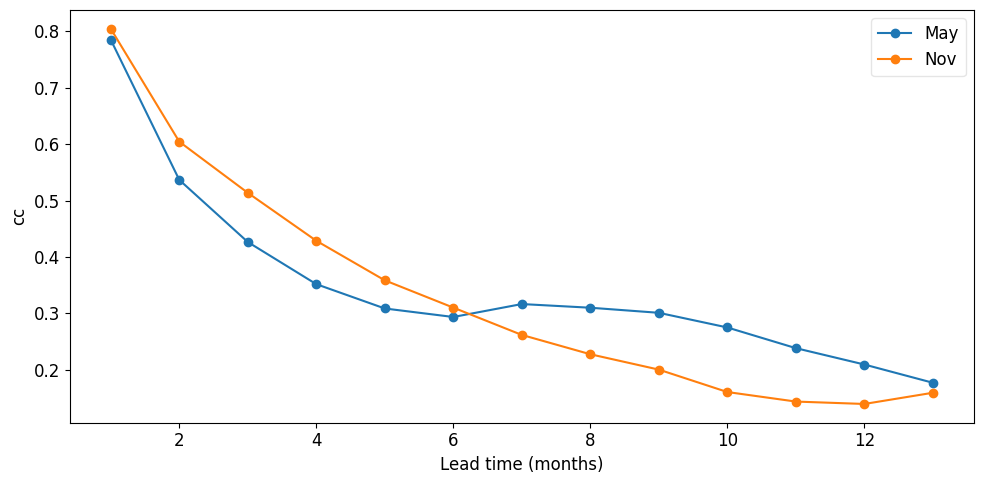

In [ ]:
score_key = 'cc'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
score = time_scores[score_key]['ssta'].groupby('time.month').mean('time')
ax.plot(score.lag, score.sel(month=5), marker='o', label='May')
ax.plot(score.lag, score.sel(month=11), marker='o', label='Nov')
ax.set_xlabel('Lead time (months)')
ax.set_ylabel(score_key)
ax.legend()

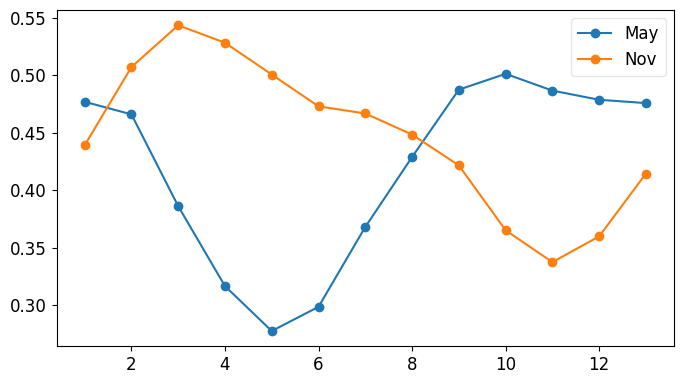

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
skill_spread = time_scores['spread_skill']['ssta'].groupby('time.month').mean('time')
ax.plot(skill_spread.lag, skill_spread.sel(month=5), 'o-', label='May')
ax.plot(skill_spread.lag, skill_spread.sel(month=11), 'o-', label='Nov')
ax.legend()

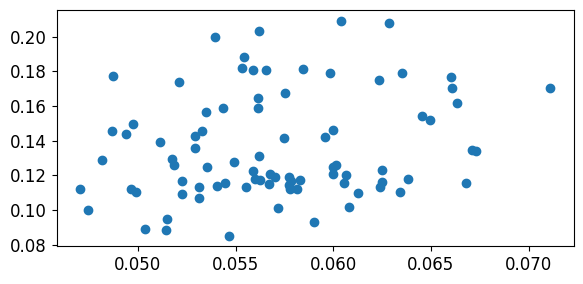

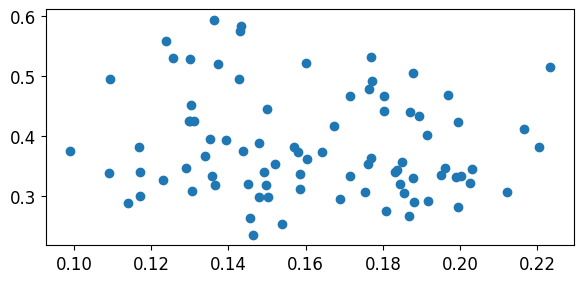

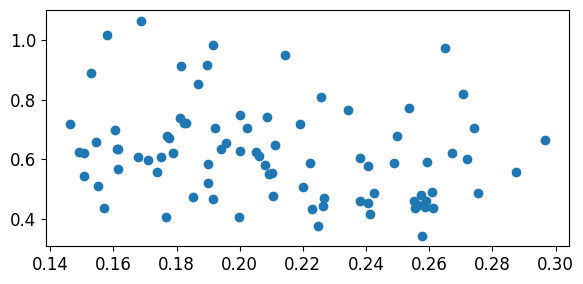

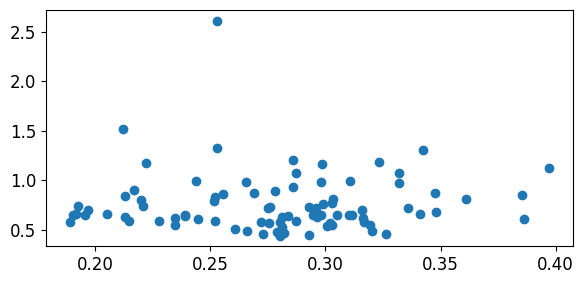

In [ ]:
for lag in [1, 3, 6, 12]:
    spread = time_scores['spread']['ssta'].sel(lag=lag)
    skill = time_scores['mse']['ssta'].sel(lag=lag)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.scatter(spread.data, skill.data, label=f"Lag {lag}")


## Nino indices

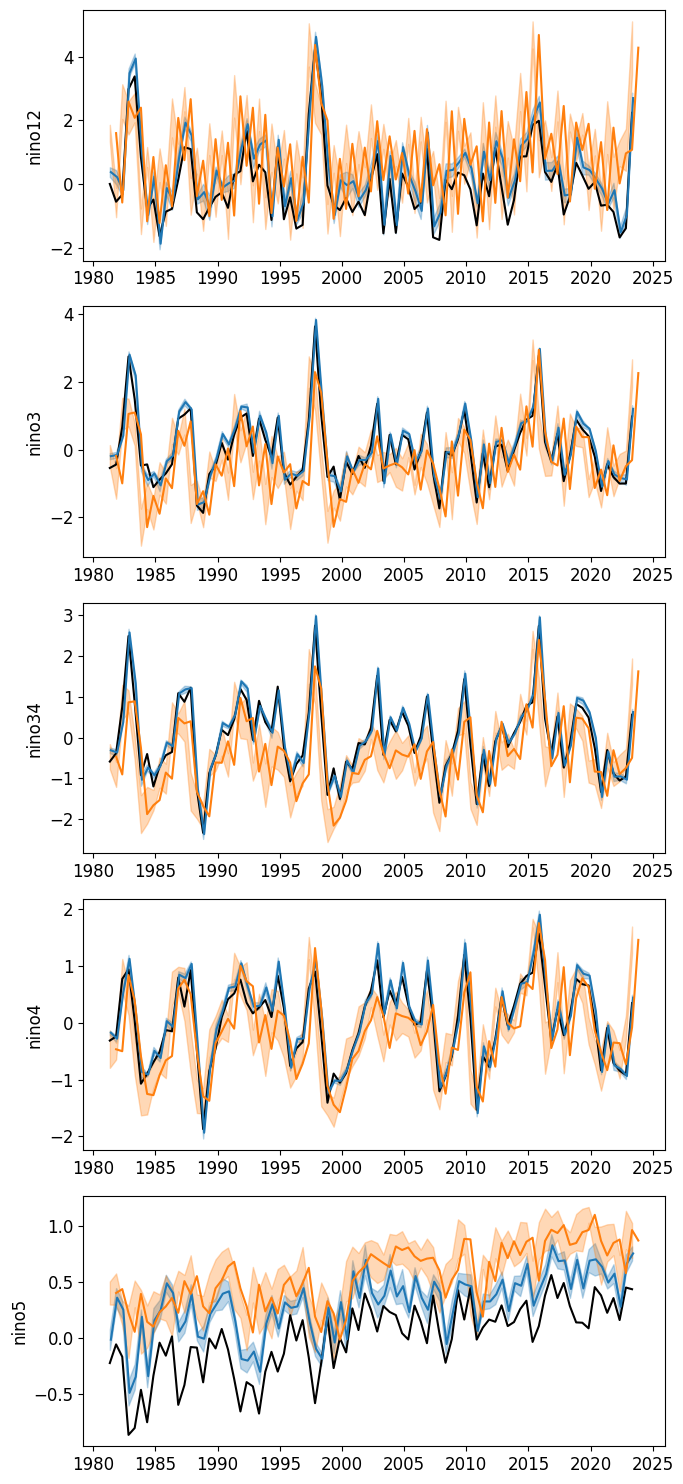

In [ ]:
# Plot Nino indices
nrows = len(nino_ids['target'].data_vars)
fig, axs = plt.subplots(nrows, 1, figsize=(7, 3*nrows))

for i, var in enumerate(nino_ids['target'].data_vars):
    ax = axs[i]
    nino_target = nino_ids['target'][var].sel(lag=1)
    ax.plot(nino_target.time, nino_target, color='k', label='target')
    for lag in [1, 6]:
        nino_frcst = nino_ids['frcst'][var].sel(lag=lag)

        dates = np.array(nino_target.time,dtype='datetime64[M]') + np.timedelta64(lag, 'M')
        pl = ax.plot(dates, nino_frcst.mean('member'), label=f'lag={lag}')
        ax.fill_between(nino_frcst.time, nino_frcst.mean('member') - nino_frcst.std('member'),
                        nino_frcst.mean('member') + nino_frcst.std('member'), color=pl[0].get_color(), alpha=0.3)
    ax.set_ylabel(var)


In [ ]:
nino_scores, nino_scores_month = metric.time_series_score(nino_ids['frcst'], nino_ids['target'])

/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']


/dev/shm/_tmpdir_.ecm1922.31485475/ipykernel_1180048/31114770.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


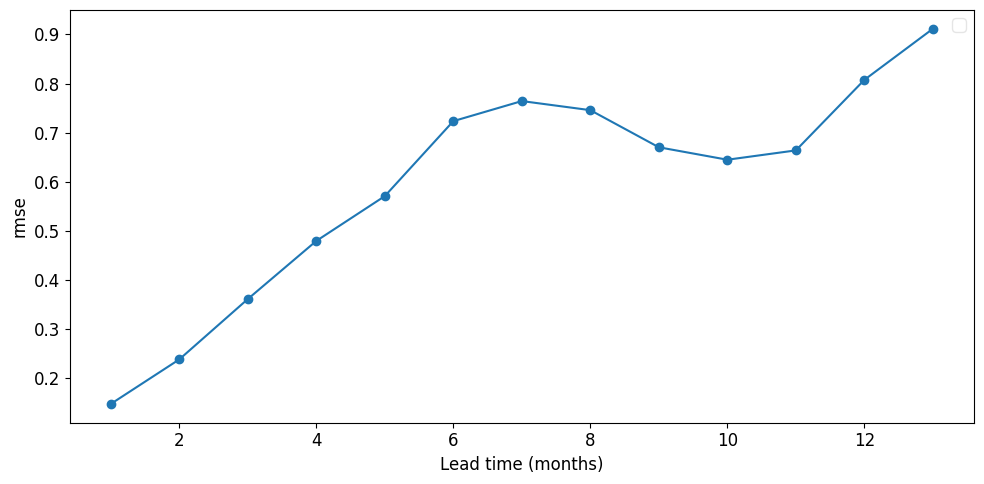

In [11]:
score_key = 'rmse'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
score = nino_scores[score_key]['nino34']
ax.plot(score.lag, score, marker='o')
ax.set_xlabel('Lead time (months)')
ax.set_ylabel(score_key)
ax.legend()

(0.0, 1.2)

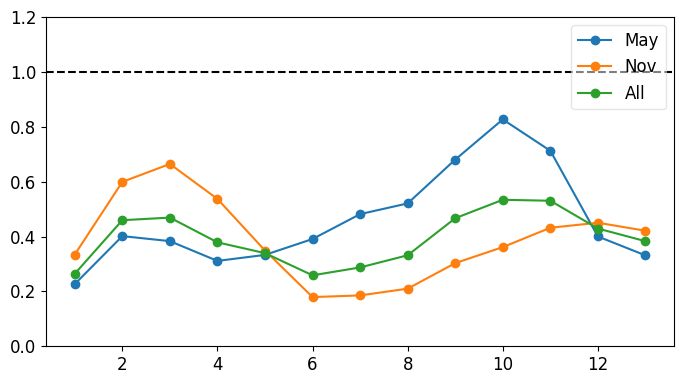

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
skill_spread = nino_scores_month['spread_skill']['nino34']
ax.plot(skill_spread.lag, skill_spread.sel(month=5), 'o-', label='May')
ax.plot(skill_spread.lag, skill_spread.sel(month=11), 'o-', label='Nov')
skill_spread = nino_scores['spread_skill']['nino34']
ax.plot(skill_spread.lag, skill_spread, 'o-', label='All')
ax.legend()
ax.axhline(1.0, color='k', linestyle='--')
ax.set_ylim(0, 1.2)

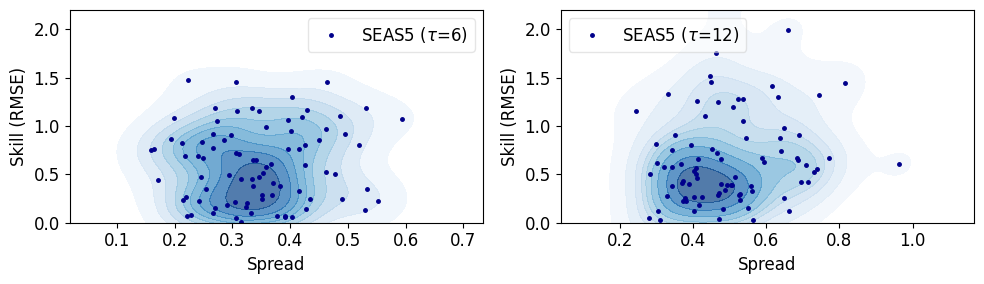

In [13]:
import seaborn as sns
lag_arr = [6, 12]
nrows = len(lag_arr)
fig, axs = plt.subplots(1, nrows, figsize=(5*nrows, 3))
for i, lag in enumerate(lag_arr):
    ax = axs[i]
    spread = nino_ids['frcst'].sel(lag=lag).std(dim='member') 
    skill = np.abs(nino_ids['frcst'].sel(lag=lag).mean(dim='member') - nino_ids['target'].sel(lag=lag))

    ax.plot(spread['nino34'].values, skill['nino34'].values, '.', markersize=5, color='darkblue', label=rf"SEAS5 ($\tau$={lag})")
    sns.kdeplot(x=spread['nino34'].values, y=skill['nino34'].values, ax=ax,
            alpha=0.7, fill=True, cmap='Blues')

    ax.legend()
    ax.set_xlabel('Spread')
    ax.set_ylabel('Skill (RMSE)')
    ax.set_ylim(0, 2.2)


## High low skill examples

In [15]:
lag = 10
percentiles = [95, 100]
skill = np.abs(nino_ids['frcst']['nino34'].sel(lag=lag).mean(dim='member') - nino_ids['target']['nino34'].sel(lag=lag))

ids_init_time = np.where(
    (nino_ids['target']['nino34'].sel(lag=1) > 0.5) &
    (skill.data >= np.percentile(skill, percentiles[0]))
    & (skill.data <= np.percentile(skill, percentiles[1]))
)[0]
ids_init_time


array([11, 57, 72])

Text(0.5, 1.0, '2009-11-01')

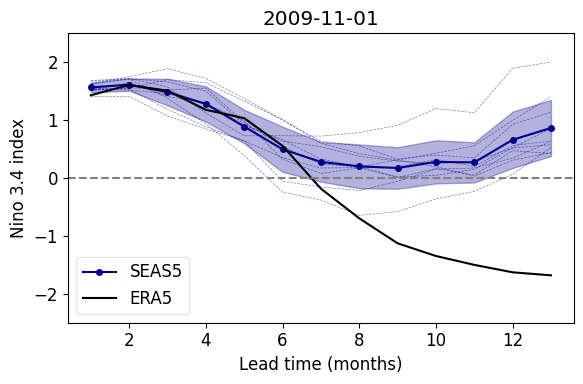

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
idx = ids_init_time[1]
frcst = nino_ids['frcst']['nino34'].isel(time=idx)
target = nino_ids['target']['nino34'].isel(time=idx)

ax.plot(frcst.lag, frcst, '--', color='darkblue', alpha=0.5, linewidth=0.5)
ax.plot(frcst.lag, frcst.mean('member'), '-o', color='darkblue', label='SEAS5', markersize=4)
ax.fill_between(frcst.lag, frcst.mean('member') - frcst.std('member'), frcst.mean('member') + frcst.std('member'), color='darkblue', alpha=0.3)
ax.plot(target.lag, target, '-', color='k', markersize=5, label='ERA5')

ax.set_xlabel('Lead time (months)')
ax.set_ylabel('Nino 3.4 index')
ax.legend(loc='lower left')
ax.axhline(0.0, color='gray', linestyle='--')
ax.set_ylim(-2.5, 2.5)
# Init time as string: yyyy-mm-dd
ax.set_title(f"{frcst.time.values.astype('datetime64[D]')}")





Text(0.5, 1.0, '2009-11-01')

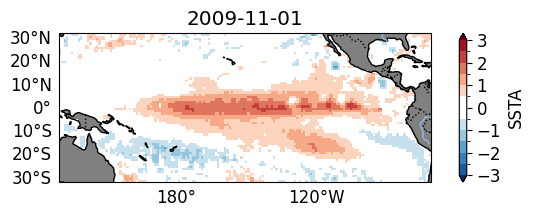

In [33]:
import hyblim.geoplot as gpl
import cartopy as ctp
pltargs = {'ssta': dict(vmin=-3, vmax=3, eps=0.5, cmap='RdBu_r', centercolor='white'),
           'ssha': dict(kwargs_pl={'colors':'k', 'levels' :[-2.5, -1.25, 1.25, 2.5], 
                            'linewidths': 1}, zerolinecolor=None, add_inline_labels=False)}
# Optimal initial pattern
date = '2009-11-01'
x_map = era5_target['ssta'].sel(time=date, lag=1)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(2,1,1, projection=ctp.crs.PlateCarree(central_longitude=180))
im = gpl.plot_map(x_map, ax=ax, 
                  **pltargs['ssta'], add_bar=True,
                  kwargs_cb=dict(label="SSTA", orientation='vertical')
)
ax.set_title(date)